# Install dependencies

In [ ]:
! pip install sentence_transformers

In [1]:
! pip install simcse

# Importing

In [2]:
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer, LoggingHandler, util, evaluation, models, InputExample
from simcse import SimCSE
import logging
import os
import gzip
import csv
import random
import numpy as np
import torch

# Initialize model

In [ ]:
model = SimCSE("princeton-nlp/sup-simcse-roberta-large")

Downloading:   0%|          | 0.00/256 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/664 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/780k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32G [00:00<?, ?B/s]

# Test embedding

In [ ]:
sentence_a = ["He is playing guitar."]
sentence_b = ["He plays the guitar."]

In [ ]:
similarity = model.similarity(sentence_a, sentence_b)
print("")
print("Score: ", similarity)

100%|██████████| 1/1 [00:00<00:00, 19.55it/s]


Score:  [[0.99022377]]


# Reduce output vector dimension

## Define new dimension for output vector

In [ ]:
new_dimension = 128

In [ ]:
nli_dataset_path = 'datasets/AllNLI.tsv.gz'
sts_dataset_path = 'datasets/stsbenchmark.tsv.gz'

In [ ]:
if not os.path.exists(nli_dataset_path):
    util.http_get('https://sbert.net/datasets/AllNLI.tsv.gz', nli_dataset_path)

if not os.path.exists(sts_dataset_path):
    util.http_get('https://sbert.net/datasets/stsbenchmark.tsv.gz', sts_dataset_path)

  0%|          | 0.00/40.8M [00:00<?, ?B/s]

  0%|          | 0.00/392k [00:00<?, ?B/s]

In [ ]:
eval_examples = []
with gzip.open(sts_dataset_path, 'rt', encoding='utf8') as fIn:
    reader = csv.DictReader(fIn, delimiter='\t', quoting=csv.QUOTE_NONE)
    for row in reader:
        if row['split'] == 'test':
            score = float(row['score']) / 5.0 #Normalize score to range 0 ... 1
            eval_examples.append(InputExample(texts=[row['sentence1'], row['sentence2']], label=score))

In [ ]:
stsb_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(eval_examples, name='sts-benchmark-test')

In [ ]:
stsb_evaluator(model)

In [ ]:
nli_sentences = set()
with gzip.open(nli_dataset_path, 'rt', encoding='utf8') as fIn:
    reader = csv.DictReader(fIn, delimiter='\t', quoting=csv.QUOTE_NONE)
    for row in reader:
        nli_sentences.add(row['sentence1'])
        nli_sentences.add(row['sentence2'])

In [ ]:
nli_sentences = list(nli_sentences)
random.shuffle(nli_sentences)

In [ ]:
for sentense in nli_sentences[0:10]:
  print(sentense)

The three men are talking and enjoying music and a beverage.
The USA voted to drop bombs.
The Old Protestant Cemetery is protected by a gate.
The boys hold unicef items.
The Postal Service surveys carriers about mail delivery weight.
A man with a beard and long hair plays the guitar.
The commission was eager  to pursue the contract rate.
Mallorca and Menorca ended up to be on different sides during the war.
Falwell had to apologize for his insensitivity.
LSC has helped millions of low-income citizens solve important, sometimes even life-threatening, civil legal problems.


In [ ]:
pca_train_sentences = nli_sentences[0:250000]
train_embeddings = model.encode(pca_train_sentences)

100%|██████████| 3907/3907 [1:14:10<00:00,  1.14s/it]


In [ ]:
import pickle
with open('embeddings_250000_1024.pkl', 'wb') as f:
  pickle.dump(train_embeddings, f)

In [ ]:
train_embeddings.shape

torch.Size([250000, 1024])

In [ ]:
pca = PCA(n_components=new_dimension)

In [ ]:
pca.fit(train_embeddings)

PCA(n_components=128)

In [ ]:
import pickle

with open("rd_pca_250000_1024_128.pkl", "wb") as f:
  pickle.dump(pca, f)

In [ ]:
pca_comp = np.asarray(pca.components_)
print(pca_comp)
print(pca_comp.shape)

[[-0.0500672   0.00126569  0.00092488 ...  0.04113474  0.02879589
  -0.00562863]
 [ 0.02808421 -0.05264069  0.04692121 ... -0.03163859  0.00675431
   0.02875423]
 [ 0.01597406  0.02458853 -0.02485786 ...  0.01123979  0.037969
   0.02756794]
 ...
 [-0.05945657  0.00354414  0.02389805 ... -0.00092136 -0.03846678
  -0.00139057]
 [-0.00096666 -0.00892628  0.00817758 ...  0.04622594  0.00237282
  -0.0574639 ]
 [ 0.03970242  0.0412358   0.06071008 ... -0.07139916  0.04939355
   0.0069946 ]]
(128, 1024)


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

sentence_1 = ["I am happy"]
sentence_2 = ["I am sad"]

emb_a = model.encode(sentence_a)
emb_b = model.encode(sentence_b)

pca_output_a = pca.transform(emb_a)
pca_output_b = pca.transform(emb_b)
pca_similarity = cosine_similarity(pca_output_a, pca_output_b)

similarity = model.similarity(sentence_a, sentence_b)

print("")
print("PCA Similarity: ", pca_similarity)
print("Model Similarity: ", similarity)

100%|██████████| 1/1 [00:00<00:00, 19.76it/s]



PCA Similarity:  [[0.99365912]]
Model Similarity:  [[0.99022377]]


In [ ]:
pca_output_a.shape

(1, 128)

# Comparison

In [2]:
from collections import Counter
import pandas as pd
import pickle
from simcse import SimCSE
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
model = SimCSE("princeton-nlp/sup-simcse-roberta-large")

Downloading:   0%|          | 0.00/256 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/664 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/780k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32G [00:00<?, ?B/s]

In [4]:
with open('./data/validation.pkl', 'rb') as f:
  dataset_val = pickle.load(f)

In [5]:
with open('./data/rd_pca_250000_1024_128.pkl', 'rb') as f:
  pca = pickle.load(f)

In [ ]:
dataset_val

In [6]:
sent_0 = dataset_val['sent0'].tolist()
sent_1 = dataset_val['sent1'].tolist()
hard_neg = dataset_val['hard_neg'].tolist()

In [10]:
import json

# Store sentences
SEN0 = []
SEN1 = []
SEN2 = []

# Store embedding vectors from model (1024 dim)
V1 = []
V2 = []

# Store embedding vectors after PCA (128 dim)
VPCA1 = []
VPCA2 = []

# Similarity between each pair of sentence from V1, V2
S01 = []
S02 = []
S12 = []
# Similarity between each pair of sentence from VPCA1, VPCA2
SPCA01 = []
SPCA02 = []
SPCA12 = []

# Similarity different


reports = dict()

i = 0
for s0, s1, hn in zip(sent_0, sent_1, hard_neg):
  print(i)

  emb_0 = model.encode([s0])
  emb_1 = model.encode([s1])
  emb_hn = model.encode([hn])

  emb_pca_0 = pca.transform(emb_0)
  emb_pca_1 = pca.transform(emb_1)
  emb_pca_hn = pca.transform(emb_hn)

  siml_01 = model.similarity([s0], [s1])
  siml_0hn = model.similarity([s0], [hn])
  siml_1hn = model.similarity([s1], [hn])

  siml_pca_01 = cosine_similarity(emb_pca_0, emb_pca_1)
  siml_pca_0hn = cosine_similarity(emb_pca_0, emb_pca_hn)
  siml_pca_1hn = cosine_similarity(emb_pca_1, emb_pca_hn)

  SEN0.append(s0)
  SEN1.append(s1)
  SEN2.append(hn)

  S01.append(siml_01[0][0])
  S02.append(siml_0hn[0][0])
  S12.append(siml_1hn[0][0])

  SPCA01.append(siml_pca_01[0][0])
  SPCA02.append(siml_pca_0hn[0][0])
  SPCA12.append(siml_pca_1hn[0][0])

  i += 1

  if i == 32:
    break

reports['sent_0'] = SEN0
reports['sent_1'] = SEN1
reports['sent_2'] = SEN2

reports['similarity_01_1024'] = [str(s) for s in S01]
reports['similarity_02_1024'] = [str(s) for s in S02]
reports['similarity_12_1024'] = [str(s) for s in S12]

reports['similarity_01_128'] = [str(s) for s in SPCA01]
reports['similarity_02_128'] = [str(s) for s in SPCA02]
reports['similarity_12_128'] = [str(s) for s in SPCA12]

reports['change_01'] = [round(abs(s - spca), 3) for s, spca in zip(S01, SPCA01)]
reports['change_02'] = [round(abs(s - spca), 3) for s, spca in zip(S02, SPCA02)]
reports['change_12'] = [round(abs(s - spca), 3) for s, spca in zip(S12, SPCA12)]

import os
if not os.path.exists('./results'):
  os.mkdir('./results')
with open('./results/dimension_reduction_reports_250000_1024_128.json', 'w') as f:
  json.dump(reports, f)

0


100%|██████████| 1/1 [00:00<00:00, 47.76it/s]


1


100%|██████████| 1/1 [00:00<00:00, 46.85it/s]


2


100%|██████████| 1/1 [00:00<00:00, 42.18it/s]


3


100%|██████████| 1/1 [00:00<00:00, 48.56it/s]


4


100%|██████████| 1/1 [00:00<00:00, 45.12it/s]


5


100%|██████████| 1/1 [00:00<00:00, 39.45it/s]


6


100%|██████████| 1/1 [00:00<00:00, 47.44it/s]


7


100%|██████████| 1/1 [00:00<00:00, 32.53it/s]


8


100%|██████████| 1/1 [00:00<00:00, 42.10it/s]


9


100%|██████████| 1/1 [00:00<00:00, 44.23it/s]


10


100%|██████████| 1/1 [00:00<00:00, 44.64it/s]


11


100%|██████████| 1/1 [00:00<00:00, 44.87it/s]


12


100%|██████████| 1/1 [00:00<00:00, 53.56it/s]


13


100%|██████████| 1/1 [00:00<00:00, 45.08it/s]


14


100%|██████████| 1/1 [00:00<00:00, 47.79it/s]


15


100%|██████████| 1/1 [00:00<00:00, 52.97it/s]


16


100%|██████████| 1/1 [00:00<00:00, 38.57it/s]


17


100%|██████████| 1/1 [00:00<00:00, 35.57it/s]


18


100%|██████████| 1/1 [00:00<00:00, 49.73it/s]


19


100%|██████████| 1/1 [00:00<00:00, 45.39it/s]


20


100%|██████████| 1/1 [00:00<00:00, 42.01it/s]


21


100%|██████████| 1/1 [00:00<00:00, 44.03it/s]


22


100%|██████████| 1/1 [00:00<00:00, 45.17it/s]


23


100%|██████████| 1/1 [00:00<00:00, 52.79it/s]


24


100%|██████████| 1/1 [00:00<00:00, 56.33it/s]


25


100%|██████████| 1/1 [00:00<00:00, 42.41it/s]


26


100%|██████████| 1/1 [00:00<00:00, 47.64it/s]


27


100%|██████████| 1/1 [00:00<00:00, 43.94it/s]


28


100%|██████████| 1/1 [00:00<00:00, 45.02it/s]


29


100%|██████████| 1/1 [00:00<00:00, 41.02it/s]


30


100%|██████████| 1/1 [00:00<00:00, 55.60it/s]


31


100%|██████████| 1/1 [00:00<00:00, 41.25it/s]


In [11]:
reports_df = pd.DataFrame(reports)

In [12]:
reports_df

,similarity_01_1024,similarity_02_1024,similarity_12_1024,similarity_01_128,similarity_02_128,similarity_12_128,change_01,change_02,change_12,sent_0,sent_1,sent_2
0,0.45042014,-0.019828876,-0.009959217,0.5110209240714892,-0.01933635094166937,-0.0015466665105723712,0.061,0.000,0.008,you know during the season and i guess at at y...,You lose the things to the following level if ...,They never perform recalls on anything.
1,0.7937212,0.31418663,0.23358503,0.8217011745241732,0.35033829429841706,0.2687643935216204,0.028,0.036,0.035,One of our number will carry out your instruct...,A member of my team will execute your orders w...,We have no one free at the moment so you have ...
2,0.70577776,0.46144637,0.30215687,0.7373643487012005,0.49575612469253055,0.3273595510900006,0.032,0.034,0.025,How do you know? All this is their information...,This information belongs to them.,They have no information at all.
3,0.8592558,0.64737165,0.7603762,0.8915928086279619,0.6854876633735985,0.7787086611047802,0.032,0.038,0.018,yeah i tell you what though if you go price so...,The tennis shoes can be in the hundred dollar ...,The tennis shoes are not over hundred dollars.
4,0.9702828,0.3401761,0.33445096,0.9800435565350278,0.37452765943375826,0.3694378301905534,0.010,0.034,0.035,my walkman broke so i'm upset now i just have ...,I'm upset that my walkman broke and now I have...,My walkman still works as well as it always did.
5,0.6671512,0.14939527,0.30175394,0.7197670418718263,0.18306470629116184,0.3391684217706775,0.053,0.034,0.037,But a few Christian mosaics survive above the ...,There are a few Christian mosaics left in the ...,There are no mosaics left in this place at all.
6,0.813905,0.42119187,0.6089175,0.8401755642716626,0.45514002056488656,0.6305207505308817,0.026,0.034,0.022,(Read for Slate 's take on Jackson's findings.),Slate had an opinion on Jackson's findings.,Slate did not hold any opinion on Jackson's fi...
7,0.78700256,0.5710188,0.80227077,0.8010451420441609,0.5851394404522312,0.8050353326521169,0.014,0.014,0.003,Gays and lesbians.,Homosexuals.,Heterosexuals.
8,0.77971363,0.4630766,0.47090083,0.8128023272461672,0.5108475645039071,0.5129189781537196,0.033,0.048,0.042,At the end of Rue des Francs-Bourgeois is what...,Place des Vosges is a very handsome area.,Place des Vosges is constructed entirely of gr...
9,0.8468641,0.37795705,0.37973744,0.8745863233484582,0.41431264082340535,0.41709462882536674,0.028,0.036,0.037,"I burst through a set of cabin doors, and fell...",I burst through the doors and fell down.,I slipped through the doors quietly.


In [14]:
reports_df.to_excel("./results/report_1024_128.xlsx", index=False)

In [ ]:
for sil, sil_pca in zip(S, SPCA):
  print(abs(float(sil) - float(sil_pca)))

In [26]:
delta_sil_01 = [round(abs(s - spca), 3) for s, spca in zip(S01, SPCA01)]
delta_sil_02 = [round(abs(s - spca), 3) for s, spca in zip(S02, SPCA02)]
delta_sil_12 = [round(abs(s - spca), 3) for s, spca in zip(S12, SPCA12)]

delta_sil = delta_sil_01 + delta_sil_02 + delta_sil_12

In [27]:
delta_sil_table = dict(Counter(delta_sil))

In [ ]:
delta_sil_table

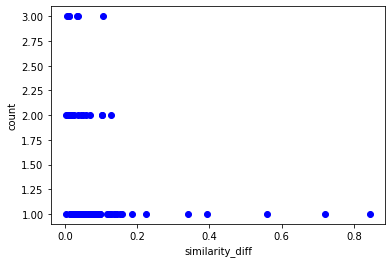

In [21]:
import matplotlib.pyplot as plt

plt.plot(list(delta_sil_table.keys()), list(delta_sil_table.values()), 'bo')
plt.xlabel('similarity_diff')
plt.ylabel('count')
plt.savefig('./results/report_1.png')
plt.show()

In [ ]:
len(delta_sil)

90

# Quick test

In [19]:
test_0 = ["I am happy."]
test_1 = ["I am excited."]
test_2 = ["I am so sad."]

In [22]:
sil_01_1024 = model.similarity(test_0, test_1)
sil_02_1024 = model.similarity(test_0, test_2)
sil_12_1024 = model.similarity(test_1, test_2)

vec_0_1024 = model.encode(test_0)
vec_1_1024 = model.encode(test_1)
vec_2_1024 = model.encode(test_2)

vec_0_128 = pca.transform(vec_0_1024)
vec_1_128 = pca.transform(vec_1_1024)
vec_2_128 = pca.transform(vec_2_1024)

sil_01_128 = cosine_similarity(vec_0_128, vec_1_128)
sil_02_128 = cosine_similarity(vec_0_128, vec_2_128)
sil_12_128 = cosine_similarity(vec_1_128, vec_2_128)

print("")
print("Sil 1024")
print("")
print(sil_01_1024, " ", sil_02_1024, " ", sil_12_1024)
print("")
print("Sil 128")
print("")
print(sil_01_128, " ", sil_02_128, " ", sil_12_128)

100%|██████████| 1/1 [00:00<00:00, 23.10it/s]


Sil 1024

[[0.7460991]]   [[0.27860242]]   [[0.23814622]]

Sil 128

[[0.77495593]]   [[0.28902593]]   [[0.23923977]]
